**IMPORTAR OS PACOTES**

In [80]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pkg_resources
import seaborn as sns
import sys
from google.colab import files
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

**IMPORTAR OS DADOS**

In [81]:
uploaded = files.upload()

Saving archive.zip to archive (1).zip


In [82]:
zip_path = '/content/archive.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

    extracted_files = os.listdir('/content/')
print(extracted_files)

['.config', '.ipynb_checkpoints', 'Miniconda3-latest-Linux-x86_64.sh', 'ambiente', 'archive.zip', 'data-dictionary.csv', 'Country-data.csv', 'requirements.txt', 'archive (1).zip', 'venv_clusterizacao.yml', 'cluster_ia', 'sample_data']


**EXPLORAR DADOS NULOS, DUPLICADOS NO DATASET**

In [83]:
# Verificar as dimensões do dataset e a presença de registros duplicados.
dados = pd.read_csv('/content/Country-data.csv')

print(f"O Dataset possui {dados.shape[0]} linhas e {dados.shape[1]} colunas.")
print(f"O Dataset possui {dados.duplicated().sum()} linhas duplicadas.")

O Dataset possui 167 linhas e 10 colunas.
O Dataset possui 0 linhas duplicadas.


In [84]:
# Verificar a existência de dados nulos
print(dados.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


In [85]:
# Análisar um breve resumo estatístco do dataset
dados.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [86]:
# Confirmar a ausência de dados nulos e identificar os tipos de dados das colunas.
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [87]:
# Primeiras 5 linhas do dataset
dados.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**QUANTOS PAÍSES EXISTEM NO DATASET?**

In [88]:
print(f"Existem {dados['country'].count()} países no Dataset.")

Existem 167 países no Dataset.


**GRÁFICOS SOBRE A FAIXA DINÂMICA DAS VARIÁVEIS**

Antes de fazer a clusterização, é importante fazer uma análise dos dados para verificar se há valores nulos, duplicados ou erros. A análise gráfica mostra que existem valores muito distantes da média, que podem ser considerados outliers, mas no caso de um dataset com dados de países em diferentes estágios de desenvolvimento, como PIB alto ou até negativo, isso é uma característica natural e não um erro.

Porém, é necessário padronizar esses dados para reduzir as grandes diferenças entre eles, sem substituir os valores, para que fiquem mais adequados para os modelos de clusterização. No caso do K-Means, se as colunas tiverem grande variação, a padronização com "Standard Scaler" é essencial.

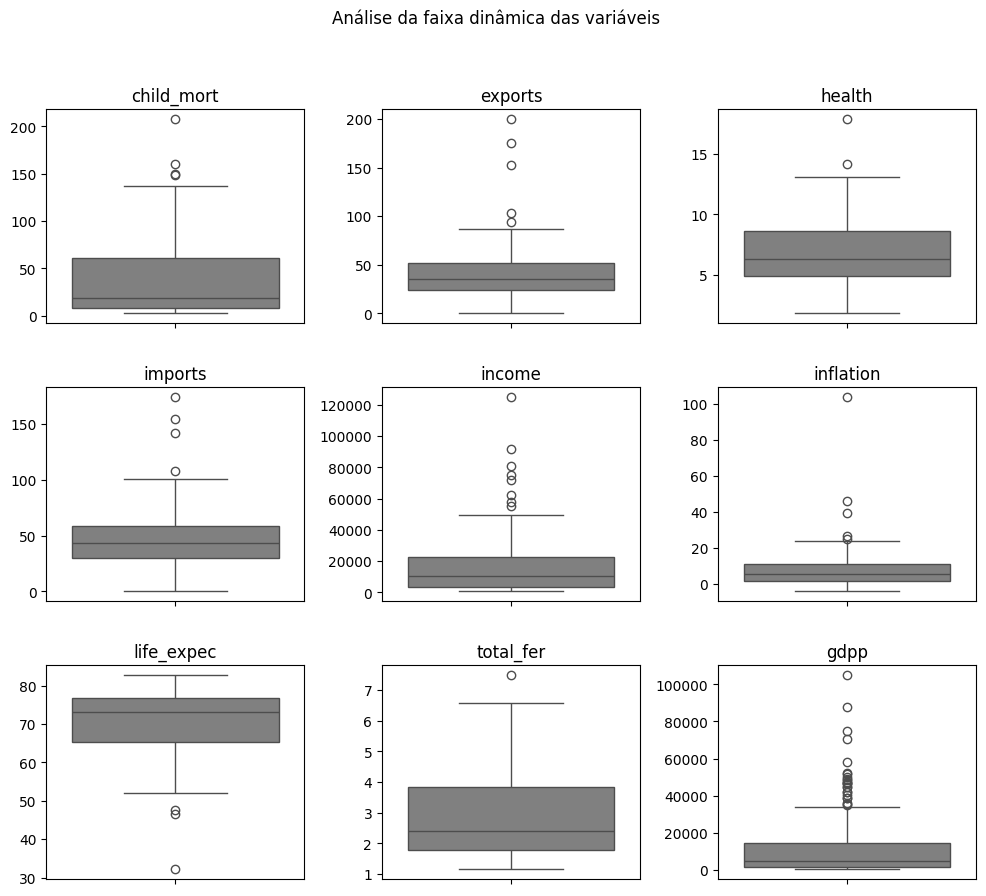

In [89]:
# Selecionar as colunas numéricas
col_num = dados.columns[1:]

# Configurar o plano de fundo dos gráficos 3 x 3
fundo, eixos = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
fundo.suptitle("Análise da faixa dinâmica das variáveis")

eixos = eixos.flatten()

# Plotar os gráficos de cada coluna através de um loop
for i, col, in enumerate(col_num):
    sns.boxplot(data=dados[1:], y=col, ax=eixos[i], color='gray')
    eixos[i].set_title(col)
    eixos[i].set_xlabel('')
    eixos[i].set_ylabel('')

# Configurar o espaçamento para não haver sobreposição
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Exibir o gráfico
plt.show()

O histograma mostra que a maioria dos países no dataset tem características típicas de nações subdesenvolvidas e em desenvolvimento.

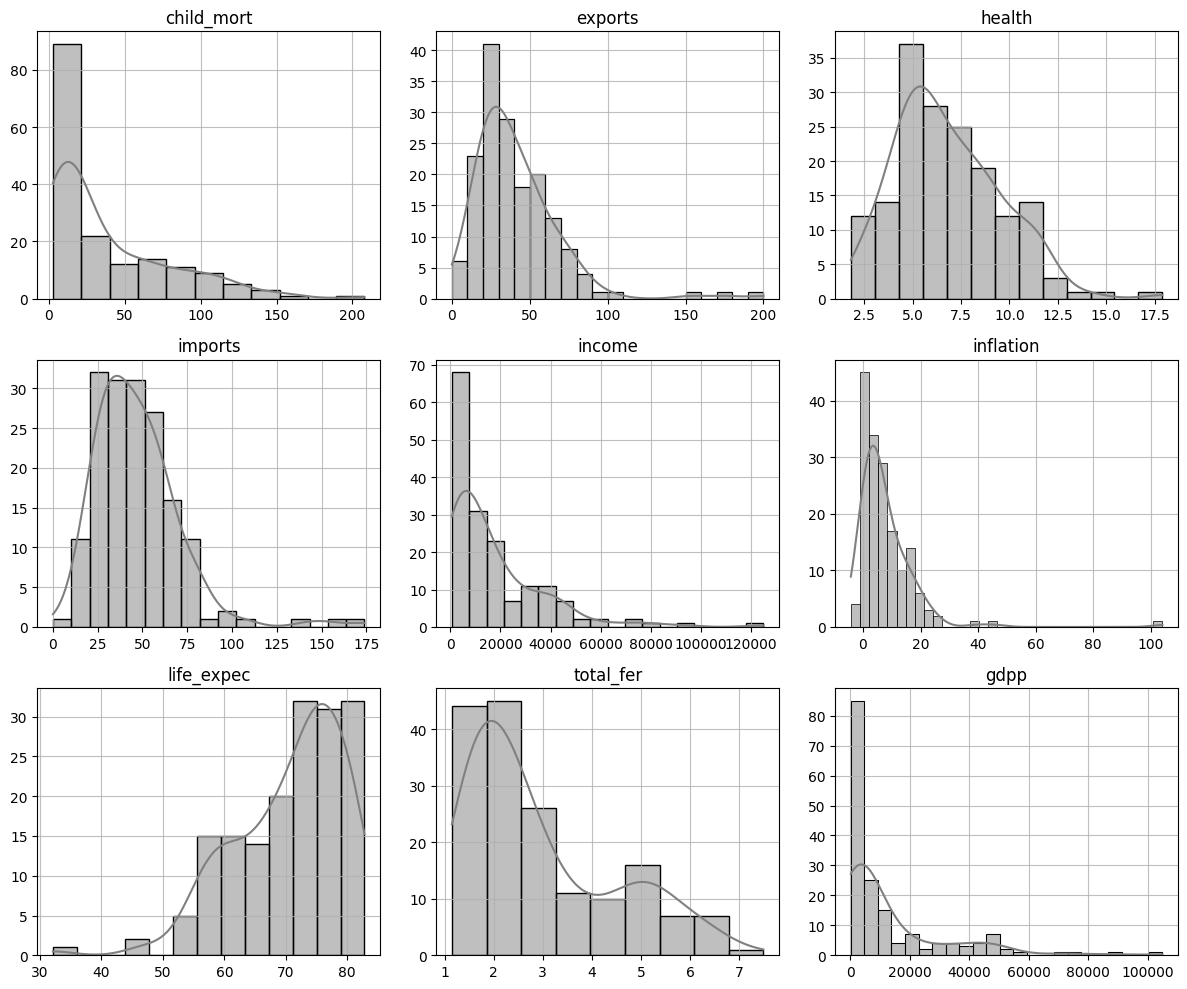

In [90]:
# Selecionar as colunas numéricas
col_num = dados.columns[1:]

# Configurar o fundo
plt.subplots(nrows=3, ncols=3, figsize=(12,10))

# Plotar os gráficos das colunas numéricas
for i in range(9):
    plt.subplot(3, 3, (i+1))
    sns.histplot(dados[col_num[i]], color='gray', kde=True).set(title=col_num[i])

    plt.xlabel ('')
    plt.ylabel ('')
    plt.grid(True, alpha=0.8)

# Garatir que não haja sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()

Ao analisar os 10 países com expectativa de vida e renda per capita abaixo do primeiro quartil, vemos semelhanças entre eles, como na República Central Africana, Moçambique e Malawi.

In [91]:
maior_mortalidade = dados[dados['life_expec'] < 65].sort_values(by='life_expec', ascending=True)
print("Países com as menores expectativas de vida")
print(maior_mortalidade[['country', 'life_expec']].head(10))

Países com as menores expectativas de vida
                      country  life_expec
66                      Haiti        32.1
87                    Lesotho        46.5
31   Central African Republic        47.5
166                    Zambia        52.0
94                     Malawi        53.1
137              South Africa        54.3
106                Mozambique        54.5
132              Sierra Leone        55.0
64              Guinea-Bissau        55.6
0                 Afghanistan        56.2


In [92]:
maior_inflação = dados[dados['income'] < 2000].sort_values(by='income', ascending=True)
print("Países com as menores rendas per captas")
print(maior_inflação[['country', 'income']].head(10))

Países com as menores rendas per captas
                      country  income
37           Congo, Dem. Rep.     609
88                    Liberia     700
26                    Burundi     764
112                     Niger     814
31   Central African Republic     888
106                Mozambique     918
94                     Malawi    1030
63                     Guinea    1190
150                      Togo    1210
132              Sierra Leone    1220


**K-MEANS**

In [93]:
# Isolar as colunas numéricas em uma variável própria, sem a necessidade de excluí-la permanentemente do código
dados_numericos = dados.drop(columns='country')

# Configurar o modelo de padronização de dados
scaler = StandardScaler(
                        copy=True,
                        with_mean=True,
                        with_std=True
                        )

# Ajustar as configurações do modelo nos dados padronizados
scaler.fit(dados_numericos)

# Padronizar os dados
dados_padronizados = scaler.transform(dados_numericos)

dados_padronizados

array([[ 1.29153238, -1.13827979,  0.27908825, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.47965843, -0.09701618, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.09912164, -0.96607302, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -2.09278484,
         1.6246091 , -0.62954556]])

In [94]:
# Configurar o modelo de clusterização dos dados (K-Means)
kmeans = KMeans(
                n_clusters=3,
                random_state=10
                )

# Ajustar as configurações do modelo nos dados padronizados
kmeans.fit(dados_padronizados)

# Atribuir novos dados aos clusters existentes
dados['clusters'] = kmeans.predict(dados_padronizados)

# Substituir os nomes dos clusters para que siga um padrão lógico
dados['clusters'] = dados['clusters'].replace({0: 2, 1: 0, 2: 1})

Mudamos os nomes dos clusters para torná-los mais claros: '0' representa os países menos desenvolvidos e '2' os mais desenvolvidos.

**ANÁLISE GRÁFICA DO DESENVOLVIMENTO ECONÔMICO**

O dataset, que inclui dados de renda per capita e expectativa de vida, permite traçar o perfil de desenvolvimento econômico dos países. A análise mostrou que existe uma relação direta: países com baixa renda per capita tendem a ter também baixa expectativa de vida.

Os grupos foram nomeados para facilitar a visualização:

**Cluster 0** inclui países com baixa expectativa de vida e renda per capita, mostrando economias mais vulneráveis.

**Cluster 1** engloba países com expectativa de vida média, mas ainda com renda per capita baixa, sugerindo economias em desenvolvimento.

**Cluster 2** reúne países com alta expectativa de vida e alta renda per capita, refletindo economias mais desenvolvidas.

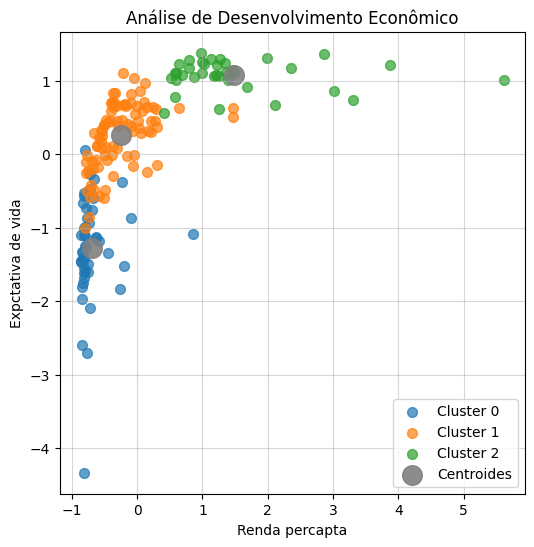

In [95]:
# Definir quais colunas eu quero analisar
eixo_x = 4  # 'renda per capta'
eixo_y = 6  # 'expectativa de vida'

# Plotar o tamanho da imagem
plt.figure(figsize=(6, 6))

# Plotar os dados
for cluster_num in range(3):
    plt.scatter(
                dados_padronizados[dados['clusters'] == cluster_num, eixo_x],
                dados_padronizados[dados['clusters'] == cluster_num, eixo_y],
                label=f"Cluster {cluster_num}",
                s=50,
                alpha=0.7
                )

# Definir os centroides
centro_kmeans = kmeans.cluster_centers_

# Plotar os centroides
plt.scatter(
            centro_kmeans[:, eixo_x],
            centro_kmeans[:, eixo_y],
            label='Centroides',
            color='gray',
            s=200,
            alpha=0.9
            )

# Configurações do gráfico
plt.title("Análise de Desenvolvimento Econômico")
plt.xlabel("Renda percapta")
plt.ylabel("Expctativa de vida")

plt.grid(visible=True, alpha=0.5)
plt.legend(loc='best')

# Mostrar o gráfico
plt.show()

**ANÁLISE POR TABELA**

Para uma análise mais técnica, foi usada uma tabela que mostra que os países do Cluster 0 têm alta taxa de mortalidade, baixa renda per capita, baixa expectativa de vida e PIB baixo, indicando economias subdesenvolvidas.

Distribuição dos clusters:

**Cluster 0:** 78,72% na África, 19,15% na Ásia e 2,13% na América do Norte (Haiti).

**Cluster 1:** 35% na Ásia, 22,5% na Europa, 16,25% na América do Norte, 13,75% na América do Sul, 10% na África e 6,25% na Oceania.

**Cluster 2:** 65,71% na Europa, 25,71% na Ásia, 5,71% na Oceania e 5,71% na América do Norte.

In [96]:
dados[(dados['clusters'] == 0)].head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,23.8,4.10,37.2,1820,0.885,61.8,5.36,758,0
21,Botswana,52.5,43.6,8.30,51.3,13300,8.920,57.1,2.88,6350,0
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.810,57.9,5.87,575,0


In [97]:
dados[(dados['clusters'] == 1)].head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
5,Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,1
6,Armenia,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,1


In [98]:
dados[(dados['clusters'] == 2)].head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,2
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,2
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,2
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,2
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,2


In [99]:
pd.DataFrame(dados.iloc[:, 1:10].mean()).T

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,38.27006,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689


**PAÍSES QUE MAIS REPRESENTAM A CLUSTERIZAÇÃO DA ANÁLISE ECONÔMICA**

Para encontrar os países que melhor representam cada cluster, usamos o método de "Pairwise Distances", que calcula a proximidade entre os dados e os centroides dos clusters.

Os países que melhor representam cada cluster são:

**Cluster 0:** Guiné (PIB e renda per capita baixos, típico de um país subdesenvolvido).

**Cluster 1:** Jamaica (PIB e renda per capita médios, caracterizando um país em desenvolvimento).

**Cluster 2:** Islândia (alto PIB e alta renda per capita, representando um país desenvolvido).

Esses países foram escolhidos por serem os mais próximos do centro de cada cluster, considerando dados como expectativa de vida e renda per capita.

In [100]:
# Encontrar o país mais próximo de cada centróide

    # X é o primeiro conjunto de pontos que quero comparar, no caso os centroides
    # Y é o segundo conjunto de pontos que quero comparar, no caso o dataset numérico

mais_proximo, distancia = pairwise_distances_argmin_min(X=centro_kmeans, Y=dados_padronizados)

# Mapear o país mais próximo de cada centróide
melhor_pais = dados.iloc[mais_proximo]

print("Países que melhor representam cada agrupamento:")
melhor_pais.sort_values(by='clusters')

Países que melhor representam cada agrupamento:


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
63,Guinea,109.0,30.3,4.93,43.2,1190,16.10,58.0,5.34,648,0
76,Jamaica,18.1,31.3,4.81,49.6,8000,9.81,74.7,2.17,4680,1
68,Iceland,2.6,53.4,9.40,43.3,38800,5.47,82.0,2.20,41900,2


**KMEDOIDS**

Para garantir que o baricentro do cluster seja, necessariamente, o dado presente no dataset que mais se aproxima do centroide, utilizaremos o modelo K-Medoid com o método de inicialização de 'k-medoid++' que calcula qual o dado que mais se aproxima do centroide do K-Means. Com isso, substituímos os centroides pelos medóides.

Esse método foi utilizada por ser a mais compatível com a métrica de 'k-means ++' (padrão do K-Means), levando a resultados mais parecidos. Também foi utilizada a mátrica 'euclidiana' de cálculo de distância, garantindo compatibilidade com o K-Means.

Como se observa o modelo do 'K-Medoid' se diferencia do método do Pariwise Distances por conta das otimizações presentes no algoritmo, ao passo em que o Pairwise realiza um cálculo simples dos dados em relação ao centroide, sem nenhuma otimização. Nesse sentido, o K-Medoid seria mais robusto sobre a varredura dos dados.

**CLUSTERIZAÇÃO HIERÁRQUICA (H-Cluster)**

In [101]:
dados.iloc[:, [1, 3]]

,child_mort,health
0,90.2,7.58
1,16.6,6.55
2,27.3,4.17
3,119.0,2.85
4,10.3,6.03
...,...,...
162,29.2,5.25
163,17.1,4.91
164,23.3,6.84
165,56.3,5.18


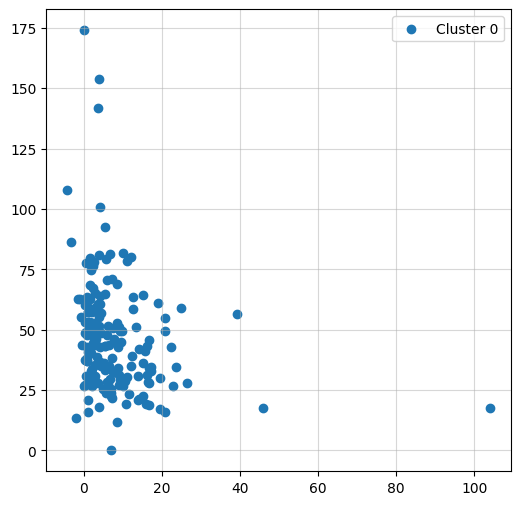

In [102]:
coluna_x = 6    # 'renda per capta'
coluna_y = 4    # 'expectativa de vida'

dados_exp = dados.iloc[:, [coluna_x, coluna_y]].values

plt.figure(figsize=(6, 6))

plt.scatter(dados_exp[:,0], dados_exp[:,1], label='Cluster 0')

plt.grid(visible=True, alpha=0.5)
plt.legend(loc='best')

# Mostrar o gráfico
plt.show()

**PREPROCESSAMENTO DOS DADOS (MinMaxScaler)**

In [103]:
# Configurar o modelo de padronização dos dados
min_max_scaler = MinMaxScaler()

# Ajustar e aplicar a formula de padronização
dados_t = min_max_scaler.fit_transform(dados_numericos)

dados_t[[4, 6]]

array([[0.03748783, 0.22707876, 0.2622747 , 0.33825512, 0.14865223,
        0.05221329, 0.8816568 , 0.15457413, 0.11424181],
       [0.07546251, 0.10351141, 0.16096955, 0.26006459, 0.04896657,
        0.11071066, 0.81262327, 0.0851735 , 0.02852943]])

In [104]:
dist_matrix = pairwise_distances(dados_t, dados_t)
print(dist_matrix)

[[0.         0.85938446 0.74311097 ... 0.8546914  0.40426303 0.22412638]
 [0.85938446 0.         0.2957055  ... 0.31085967 0.58498839 0.84241764]
 [0.74311097 0.2957055  0.         ... 0.41013299 0.38283615 0.69477761]
 ...
 [0.8546914  0.31085967 0.41013299 ... 0.         0.59790897 0.81790284]
 [0.40426303 0.58498839 0.38283615 ... 0.59790897 0.         0.36781892]
 [0.22412638 0.84241764 0.69477761 ... 0.81790284 0.36781892 0.        ]]


**IMPLEMENTAR O MODELO**

In [105]:
# Configurações do modelo
hcluster1 = AgglomerativeClustering(
                                distance_threshold=0,
                                metric='euclidean',
                                n_clusters=None
                                )

# Ajustar as configurações do modelo nos dados
hcluter1 = hcluster1.fit(dados_numericos)

**ANÁLISE DO DENDROGRAMA**

A análise revelou que, ao aplicar o K-Means com diferentes números de clusters, a maior distância entre as interseções foi observada com quatro clusters, com um valor de "60.578,58", enquanto com três clusters o valor foi "34.751,23". Isso sugere que três clusters podem ser mais adequados, já que a divisão com quatro clusters resultou em grupos bastante próximos, quase formando um único cluster.

Além disso, a análise dos gráficos mostrou que os dados estão muito agrupados, o que indica a necessidade de aplicar uma técnica de redução de dimensionalidade para uma análise mais precisa.

In [106]:
# Plotar o dendrograma
def plot_dendrogram(model, top_n=4, **kwargs):

    # Inicializa a contagem de elementos (países) em cada nó
    n_samples = len(model.labels_)
    counts = np.zeros(model.children_.shape[0])

    # Conta o número de elementos para cada nó
    for i, merge in enumerate(model.children_):
        # Verifica o primeiro filho
        if merge[0] < n_samples:
            count_1 = 1  # Conta 1 se o valor não está entre parênteses
        else:
            count_1 = counts[merge[0] - n_samples]  # Soma o valor acumulado se está entre parênteses

        # Verifica o segundo filho
        if merge[1] < n_samples:
            count_2 = 1  # Conta 1 se o valor não está entre parênteses
        else:
            count_2 = counts[merge[1] - n_samples]  # Soma o valor acumulado se está entre parênteses

        # A contagem do cluster atual é a soma das contagens dos filhos
        counts[i] = count_1 + count_2

    # Cria a matriz de linkage com as contagens corretas
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Identifica as 4 maiores distâncias e desenha linhas vermelhas
    maiores_distancias = sorted(model.distances_)[-top_n:]
    maiores_distancias = sorted(maiores_distancias, reverse=True)

    for i, altura in enumerate(maiores_distancias):
        # Desenha a linha vermelha
        plt.axhline(y=altura, color='red', linestyle='--', linewidth=1)

        # Exibe a distância e a contagem de clusters
        if i < len(maiores_distancias) - 1:
            next_altura = maiores_distancias[i + 1]
            distancia_linhas = altura - next_altura
            meio = (altura + next_altura) / 2

            # Calcula o número de clusters entre essa linha e a próxima
            cluster_count = np.sum(model.distances_ >= altura) + 1  # +1 para incluir o cluster atual

            # Exibe a distância e a contagem de clusters
            plt.text(x=1, y=meio, s=f"Distância: {distancia_linhas:,.2f}",
                     ha='left', va='center', color='red')

    # Plota o dendrograma
    dendro = dendrogram(linkage_matrix, **kwargs)

    # Adiciona a quantidade de dados em cada nó
    plt.text(x=70, y=(maiores_distancias[0] - 10000), s="(167)", ha='center', va='center', color='black')
    plt.text(x=110, y=(maiores_distancias[1] - 10000), s="(143)", ha='center', va='center', color='black')
    plt.text(x=30, y=(maiores_distancias[2] - 10000), s="(24)", ha='center', va='center', color='black')
    plt.text(x=50, y=(maiores_distancias[3] - 10000), s="(20)", ha='center', va='center', color='black')
    plt.text(x=13, y=(maiores_distancias[3] - 15000), s="(4)", ha='center', va='center', color='black')
    plt.text(x=130, y=(maiores_distancias[3] - 16000), s="(35)", ha='center', va='center', color='black')
    plt.text(x=90, y=(maiores_distancias[3] - 22000), s="(108)", ha='center', va='center', color='black')

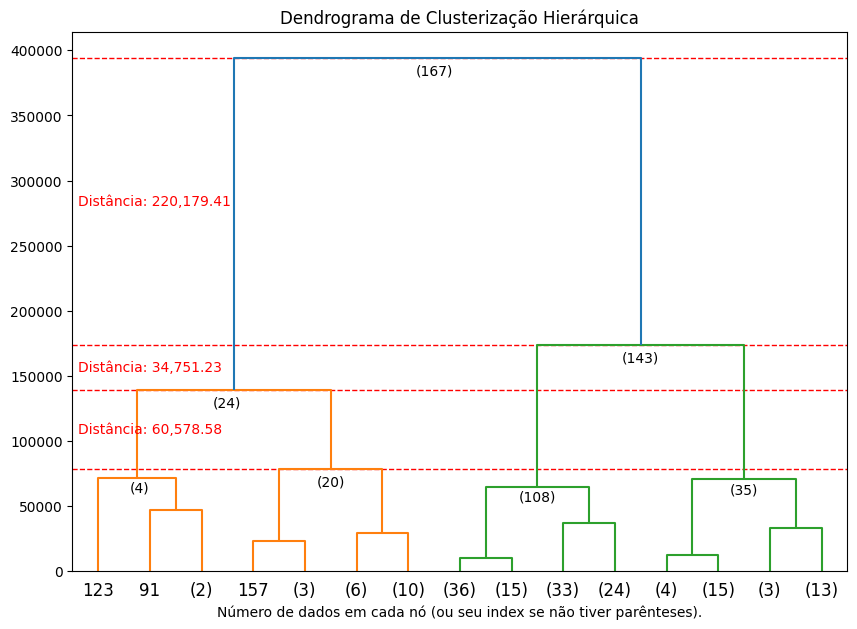

In [107]:
# Configuração da figura
plt.figure(figsize=(10, 7))
plt.title('Dendrograma de Clusterização Hierárquica')
plot_dendrogram(hcluster1, truncate_mode='level', p=3)
plt.xlabel("Número de dados em cada nó (ou seu index se não tiver parênteses).")
plt.show()

**PROPOSTAS COM 4 CLUSTERS**

Apesar de ser o número mais representativo para a distância entre os clusters, o agrupamento em 4 clusters tornou a análise mais complexa, principalmente sem usar técnicas de redução de dimensionalidade.

In [108]:
n_cluster2 = 4
hcluster2 = AgglomerativeClustering(n_clusters=n_cluster2,
                                  metric='euclidean',
                                  linkage='ward'
                                  )
cluster_label = hcluster2.fit_predict(dados_numericos)


hcluster2.labels_

array([2, 2, 2, 2, 3, 3, 2, 0, 0, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2,
       3, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       0, 2, 2, 2, 2, 3, 2, 3, 2, 0, 0, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2,
       2, 3, 0, 2, 2, 2, 2, 0, 3, 0, 2, 0, 2, 3, 2, 2, 0, 2, 2, 3, 2, 2,
       2, 3, 3, 1, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 3, 2, 2, 3,
       2, 0, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 0, 0, 0, 3, 2, 2, 3, 2, 2, 2])

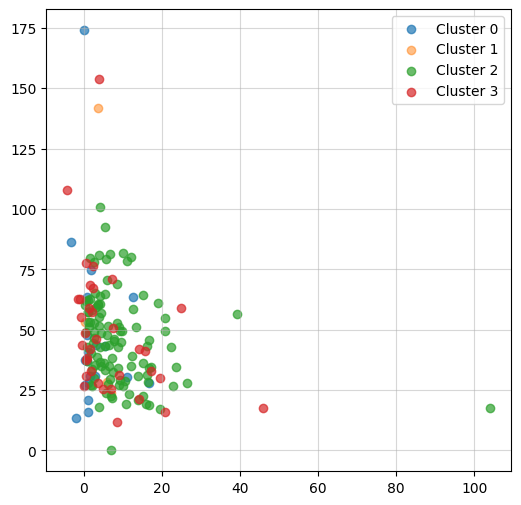

In [109]:
# Plotar o novo gráfico (precisa da execução do 5.1)
coluna_x = 6    # 'renda per capta'
coluna_y = 4    # 'expectativa de vida'

dados['h_cluster2'] = cluster_label

h_dados1 = dados[dados.h_cluster2 == 0].iloc[:, [coluna_x, coluna_y]].values
h_dados2 = dados[dados.h_cluster2 == 1].iloc[:, [coluna_x, coluna_y]].values
h_dados3 = dados[dados.h_cluster2 == 2].iloc[:, [coluna_x, coluna_y]].values
h_dados4 = dados[dados.h_cluster2 == 3].iloc[:, [coluna_x, coluna_y]].values

plt.figure(figsize=(6, 6))

plt.scatter(h_dados1[:,0], h_dados1[:,1], alpha=0.7, label=f'Cluster 0')
plt.scatter(h_dados2[:,0], h_dados2[:,1], alpha=0.5, label=f'Cluster 1')
plt.scatter(h_dados3[:,0], h_dados3[:,1], alpha=0.7, label=f'Cluster 2')
plt.scatter(h_dados4[:,0], h_dados4[:,1], alpha=0.7, label=f'Cluster 3')

#for i in set(hcluster2.labels_):
    # Plotar os dados
#plt.scatter(dados_exp[:,0], dados_exp[:,1], c=hcluster2.labels_, cmap='rainbow', label=f'Cluster {i}')

plt.grid(visible=True, alpha=0.5)

plt.legend(loc='best')

# Mostrar o gráfico
plt.show()

**DBScan**

In [110]:
# Configurar o modelo de clusterização dos dados (DBSCAN)
dbscan = DBSCAN(
                eps=1.2,
                min_samples=4,
                metric = 'euclidean',
                p=2
                )

# Ajustar as configurações do modelo nos dados padronizados
dbscan.fit(dados_padronizados)

pontos_centrais = np.zeros_like(dbscan.labels_, dtype=bool)
pontos_centrais[dbscan.core_sample_indices_] = True

db_labels = dbscan.labels_

n_cluster3 = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

# Adicionar uma coluna no dataset
dados['db_clusters'] = db_labels

In [111]:
dados.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters,h_cluster2,db_clusters
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,2,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,2,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,2,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,2,-1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1,3,1


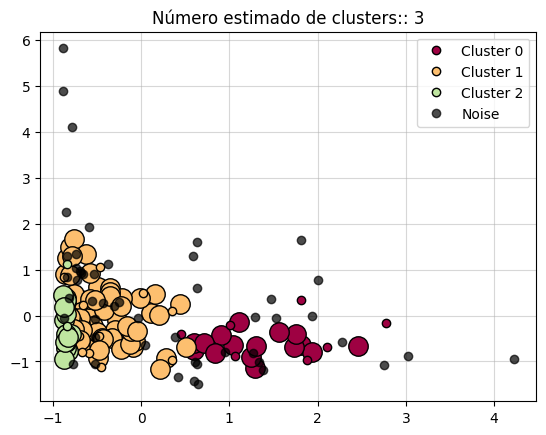

In [112]:
# Plotar um gráfico

labels_unicas = set(db_labels)
cores = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels_unicas))]

for i, ruido_cor in zip(labels_unicas, cores):

    # se for ruído,será preto
    if i == -1:
        ruido_cor = [0, 0, 0, 1]

    pontos_cluster = (db_labels == i)

    xy = dados_padronizados[pontos_cluster & pontos_centrais]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor=tuple(ruido_cor),
             markeredgecolor='k',
             markersize=14)

    xy = dados_padronizados[pontos_cluster & ~pontos_centrais]
    if i == -1:
        plt.plot(xy[:, 0], xy[:, 1], 'o',
                markerfacecolor=tuple(ruido_cor),
                markeredgecolor='k',
                markersize=6,
                alpha=0.7,
                label=f'Noise')

    else:
        plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor=tuple(ruido_cor),
             markeredgecolor='k',
             markersize=6,
             label=f'Cluster {i}')

plt.title('Número estimado de clusters:: %d' % n_cluster3)
plt.grid(visible=True, alpha=0.5)
plt.legend(loc='best')
plt.show()

**TESTES DE ACURÁCIA**

In [113]:
n_cluster3 = 3
hcluster3 = AgglomerativeClustering(n_clusters=n_cluster3,
                                  metric='euclidean',
                                  linkage='ward'
                                  )
cluster_label2 = hcluster3.fit_predict(dados_numericos)

dados['hcluster'] = cluster_label2

# Substituir os nomes dos clusters para que siga um padrão lógico
dados['hcluster'] = dados['hcluster'].replace({0: 2, 1: 0, 2: 1})

In [114]:
print(f"Acurácia entre K-Means e DBSCAN: {(100 * (metrics.accuracy_score(dados['clusters'], dados['db_clusters']))):,.2f}%")
print(f"Acurácia entre K-Means e HCluster: {(100 * (metrics.accuracy_score(dados['clusters'], dados['hcluster']))):,.2f}%")
print(f"Acurácia entre DBSCAN e HCluster: {(100 * (metrics.accuracy_score(dados['db_clusters'], dados['hcluster']))):,.2f}%")

Acurácia entre K-Means e DBSCAN: 65.87%
Acurácia entre K-Means e HCluster: 52.10%
Acurácia entre DBSCAN e HCluster: 40.12%
